## Testing Modeling and basic summary stats

In [1]:
# Setup
import os
import pandas as pd
import yaml
from sqlalchemy import create_engine, text
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import warnings
import os

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from sklearn.metrics import mean_squared_error, r2_score 

from lazypredict.Supervised import LazyRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression, PoissonRegressor, Ridge, Lasso

# Connect to database (debug this)
# db_uri = os.getenv('ERUKA_DB')
# db_engine = create_engine(db_uri)

with open('../database.yaml', 'r') as f:
    db_params = yaml.safe_load(f)

engine = create_engine('postgresql://{user}:{password}@{host}:{port}/{dbname}'.format(
  host=db_params['host'],
  port=db_params['port'],
  dbname=db_params['db'],
  user=db_params['user'],
  password=db_params['pass']    
))

In [9]:
sql = '''SELECT parcelid, building_value,
                    year as "appraisal_target_year",
                    case when handwritten is True then 1 else 0 end as "appraisal_handwritten_flag"
                FROM samples.building_values WHERE building_value is not null'''
                
df = pd.read_sql(sql, engine)

df        

,parcelid,building_value,appraisal_target_year,appraisal_handwritten_flag
0,0590006004100,3140.00,NaN,0
1,1190001019100,4270.00,NaN,0
2,1790077012500,3250.00,NaN,0
3,2430003008600,2720.00,NaN,0
4,0380006005600,4910.00,NaN,0
...,...,...,...,...
12264,5960008001800,4270.00,57.00,1
12265,5960009008700,9840.00,51.00,1
12266,6610001015300,1820.00,NaN,0
12267,6610001015500,3380.00,57.00,1


In [17]:
df1 = pd.read_csv('C:/Users/mihir/Downloads/carb-then-oc-fine-tuning-10k-raw-predictions_0.csv')

df2 = pd.read_csv('C:/Users/mihir/Downloads/carb-then-oc-fine-tuning-10k-raw-predictions_0.csv')

df = pd.concat([df1, df2])

df = df[['parcelid', 'prediction', 'score']]

df.to_csv('C:/Users/mihir/gitclones/ErukaExp/modeling_pipeline/ocr_results.csv')


In [ ]:
    # Plot to see if results vary by certain characteristics:
    
    # Merging X_test with error
    error = y_pred - y_test
    error = error.reshape(-1, 1)
    error_info = np.hstack((X_test, error))
    
    f, ax = plt.subplots(figsize=(10,10))

    # Scatterplot of test errors, colored by style
    ax.scatter(error_info[:, -1],
                np.argmax(error_info[:, colnames.index('style_Bi Level'):colnames.index('style_nan')+1], axis=1),
                c=error_info[:, colnames.index('style_Bi'):colnames.index('style_nan')+1])

    # Set axis labels using column names
    ax.set_xlabel('error')
    ax.set_ylabel('style')
    plt.set_title('style against error')

    # Set legend
    ax.legend(['style_Bi Level', 'style_Conventional', 'style_Multi Level', 'style_nan'])
    
    
    # Varying by style

Text(0, 0.5, 'Test RMSE')

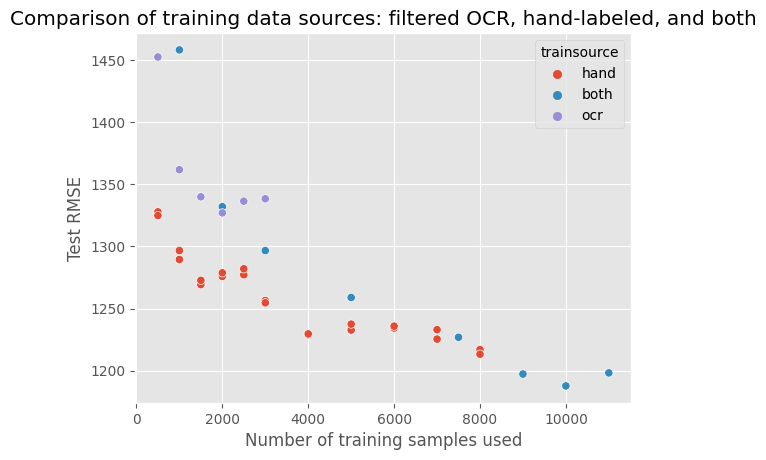

In [5]:
# Creating graph of ocr vs not

df = pd.read_csv('C:/Users/mihir/Downloads/ocr_vs_hand.csv')
hand_only = df[df['trainsource'] == 'hand'][['trainsource', 'n', 'test_rmse']]
hand_only

ocr = pd.read_csv('C:/Users/mihir/Downloads/ocr_filter.csv')
ocr = ocr[['trainsource', 'n', 'test_rmse']]

df = pd.concat([hand_only, ocr])

# ocr_only = df[df['trainsource' == 'ocr']]
# hand_only = df[df['trainsource' == 'hand']]
# both = df[df['trainsource' == 'both']]

plt.style.use('ggplot')
sns.scatterplot(data=df, x='n', y = 'test_rmse', hue = 'trainsource')
plt.title('Comparison of training data sources: filtered OCR, hand-labeled, and both')
plt.xlabel('Number of training samples used')
plt.ylabel('Test RMSE')



### 1. Read data

In [4]:
def read_labels(engine, keep='all'):
    '''
    args:
        - sql engine object
        - keep: either 'all' (all labeled points) or 
                'simple' (remove nonstandard cases where year is entered or card is handwritten)
    '''

    if keep == 'all':
        sql = 'SELECT * FROM samples.building_values WHERE building_value is not null'

    if keep == 'simple':
        sql = '''SELECT parcelid, building_value
                 FROM samples.building_values 
                 WHERE year is null and handwritten is null and building_value is not null'''

    return pd.read_sql(sql, engine)

def read_features(engine):
    sql = '''
             SELECT parcelid,
                    bi.attic_sqft, bi.bsmt_sqft, bi.live_sqft, bi.sqft_flr1, 
                    bi.sqft_flr2, bi.sqft_flrh, bi.story_ht, bi.year_built, bi.prop_class_code, bi.class_description,
                    bi.live_sqft_prop,

                    hs.number_of_parcels, hs.date_of_sale, hs.appraisal_area, hs.total_sales_records, hs.sale_price,
                    hs.style, hs.grade, hs.exterior_wall_type, hs.basement, hs.heating, hs.air_conditioning, hs.total_rooms,
                    hs.full_bath, hs.half_bath, hs.fireplaces, hs.garage_type, hs.finished_sq_ft, hs.total_finish_area,
                    hs.first_floor_area, hs.half_floor_area, hs.finished_basement, hs.garage_capacity, 
                    hs.grade_grouped, hs.grade_numeric, hs.basement_grouped, hs.garage_type_grouped

            FROM processed.building_info bi JOIN processed.historic_sales hs USING(parcelid)
         '''
    
    return pd.read_sql(sql, engine)
                

def read_data(engine, keep='all'):
    labels = read_labels(engine, keep)
    features = read_features(engine)

    merged = pd.merge(labels, features, on='parcelid')

    if len(labels) != len(merged):
        warnings.warn(f"There are {len(labels) - len(merged)} labeled rows getting dropped when merging to feature data.") 
    
    if merged['prop_class_code'].isna().sum() > 0:
        warnings.warn(f"There is missing feature data for labels where there shouldn't be.")

    return merged


In [5]:
df = read_data(engine, keep='simple')
df.head()

In [5]:
# Some basic sanity checks
print(f"There are {len(df)} labeled observations")
print(df.columns)


There are 4825 labeled observations
Index(['parcelid', 'building_value', 'attic_sqft', 'bsmt_sqft', 'live_sqft',
       'sqft_flr1', 'sqft_flr2', 'sqft_flrh', 'story_ht', 'year_built',
       'prop_class_code', 'class_description', 'number_of_parcels',
       'date_of_sale', 'appraisal_area', 'total_sales_records', 'sale_price',
       'style', 'grade', 'exterior_wall_type', 'basement', 'heating',
       'air_conditioning', 'total_rooms', 'full_bath', 'half_bath',
       'fireplaces', 'garage_type', 'finished_sq_ft', 'total_finish_area',
       'first_floor_area', 'half_floor_area', 'finished_basement'],
      dtype='object')


### 2. Data exploration

In [6]:
# For variables that have missing values, what is the % missing?
null_perc = df.isna().mean()
null_perc = null_perc[null_perc > 0]
null_perc

number_of_parcels     0.00
date_of_sale          0.00
total_sales_records   0.00
sale_price            0.13
style                 0.00
basement              0.00
garage_type           0.48
dtype: float64

Distribution of initial building value
count    4825.00
mean     3485.43
std      2414.88
min       100.00
25%      2260.00
50%      3080.00
75%      4090.00
max     57700.00
Name: building_value, dtype: float64


[Text(0.5, 1.0, 'Histogram of labeled building value')]

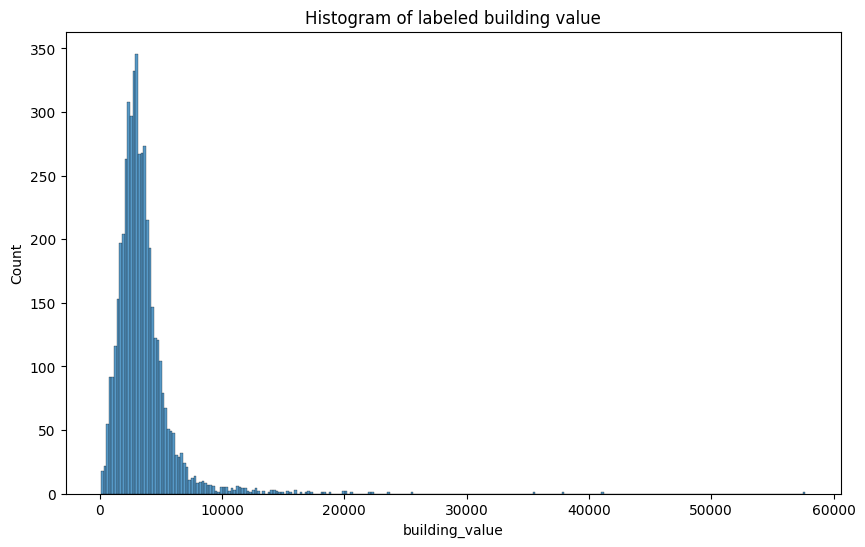

In [7]:
# Distribution of the outcome variable
print('Distribution of initial building value')
print(df['building_value'].describe())

plt.figure(figsize=(10, 6))
sns.histplot(df, x='building_value').set(title='Histogram of labeled building value')

In [8]:
## When were these properties built?
print('Distribution of build year')
print(df['year_built'].describe())

Distribution of build year
count   4825.00
mean    1910.81
std       16.08
min     1812.00
25%     1900.00
50%     1915.00
75%     1924.00
max     1929.00
Name: year_built, dtype: float64


In [9]:
## How large are these buildings?
print('Distribution of building size')
print(df['live_sqft'].describe())

Distribution of building size
count    4825.00
mean     1770.76
std       804.97
min       484.00
25%      1248.00
50%      1594.00
75%      2099.00
max     10866.00
Name: live_sqft, dtype: float64


In [11]:
## Correlations between the outcome and numeric variables
df.corrwith(df['building_value'], numeric_only=True).sort_values()

appraisal_area        -0.15
number_of_parcels     -0.02
total_sales_records   -0.00
sqft_flrh              0.06
prop_class_code        0.14
finished_basement      0.15
story_ht               0.18
sale_price             0.27
half_bath              0.28
year_built             0.31
attic_sqft             0.31
finished_sq_ft         0.39
fireplaces             0.39
full_bath              0.41
half_floor_area        0.47
sqft_flr2              0.47
total_rooms            0.49
first_floor_area       0.57
sqft_flr1              0.57
bsmt_sqft              0.63
total_finish_area      0.63
live_sqft              0.63
building_value         1.00
dtype: float64

### 3. Prep data for modeling: feature transformations, train-test split

In [4]:
def split_data(df, test_size = 0.2, random_state = 4):
    y = df['building_value']
    X = df.drop(columns=['parcelid', 'building_value', 'date_of_sale', 'class_description']) # can consider doing something with date_of_sale later

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = test_size, random_state = random_state)

    return X_train, X_test, y_train, y_test


def process_features(X_df):
        
    # Todo: convert categorical variables to one-hot, after doing some clubbing
    # style, grade, exterior wall type, basement, heating, aircon, garage type

    # keep only numeric features so we don't run into problems with different classes (e.g. linear regression),
    # but can relax this later
    X_df = X_df.select_dtypes(['number'])

    # use a simple imputation to address missing values (do something more sophisticated later)
    imp = SimpleImputer(strategy='mean')
    X_df = imp.fit_transform(X_df)

    # use a standard scaler so we don't run into issues with regularization
    scaler = StandardScaler().fit(X_df)
    X_df = scaler.transform(X_df)

    return X_df
    

In [6]:
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)



In [ ]:
import numpy as np

#X_train = X_train.to_numpy()
np.savetxt(f"modeling_pipeline/matrices/X_train.csv", X_train, delimiter=',')


### Train and evaluate some models

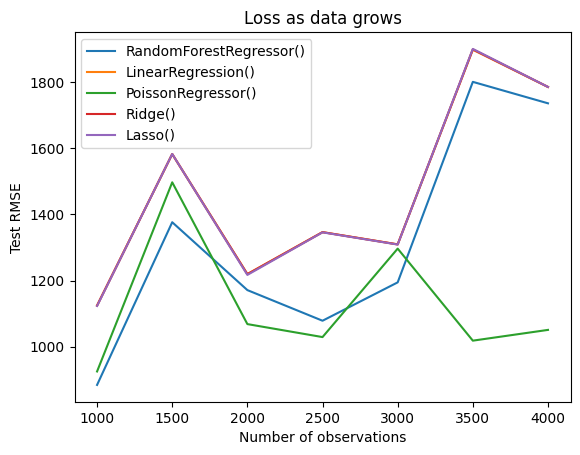

In [26]:
# Training loop across number of observations
n_list = [1000, 1500, 2000, 2500, 3000, 3500, 4000]

models = [RandomForestRegressor(), LinearRegression(), PoissonRegressor(), 
          Ridge(), Lasso()]

fig = plt.figure()

for model in models:
   test_rmse = []
   for n in n_list:
      df_s = df.sample(n, random_state=4)
      X_train, X_test, y_train, y_test = split_data(df_s, test_size=0.2)
      X_train = process_features(X_train)
      X_test = process_features(X_test)
      
      model.fit(X_train, y_train)
      y_pred = model.predict(X_test)
      rmse = mean_squared_error(y_test, y_pred, squared=False)
      test_rmse.append(rmse)
      
   plt.plot(n_list, test_rmse, label=model)
      
plt.xlabel('Number of observations')
plt.ylabel('Test RMSE')
plt.title('Loss as data grows')
plt.legend()
plt.show()

   

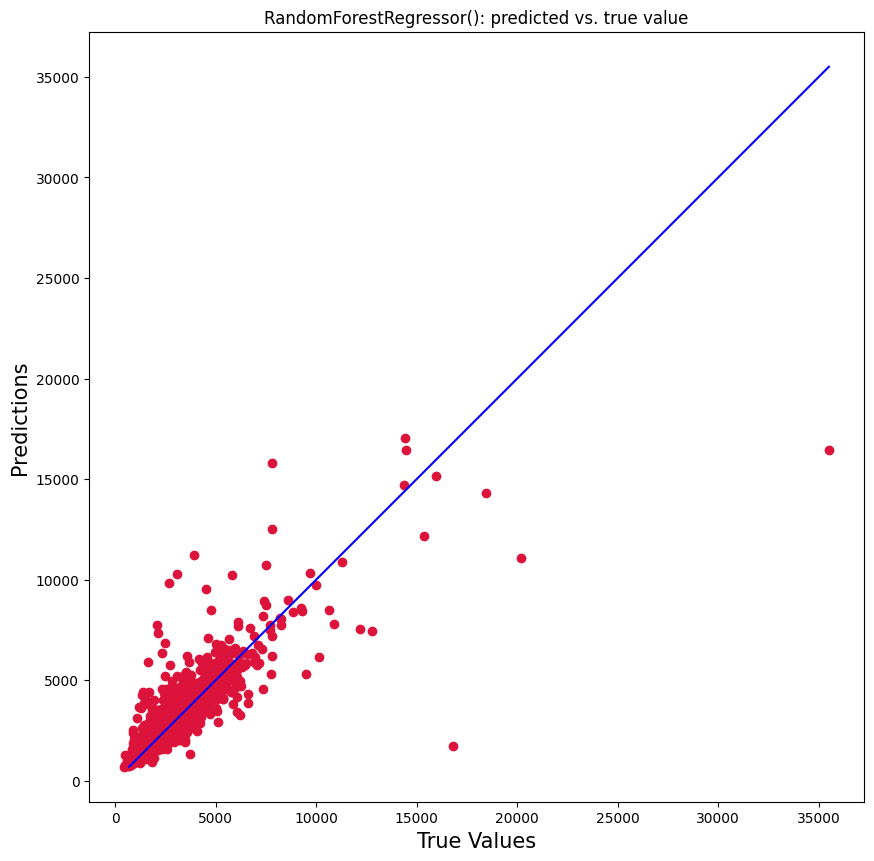

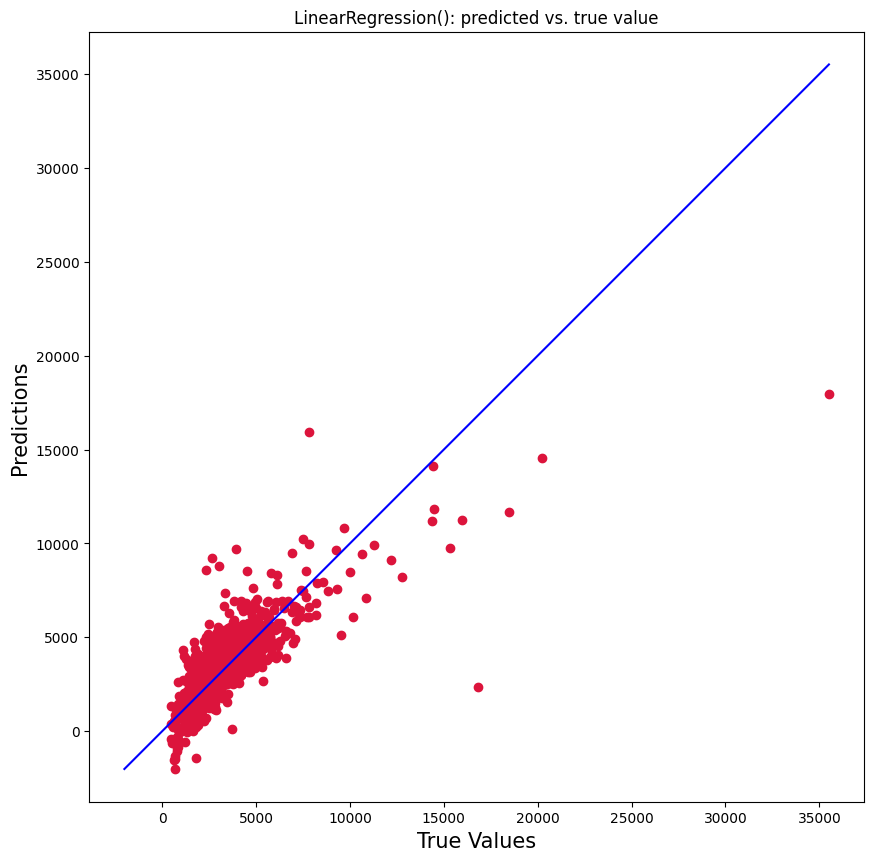

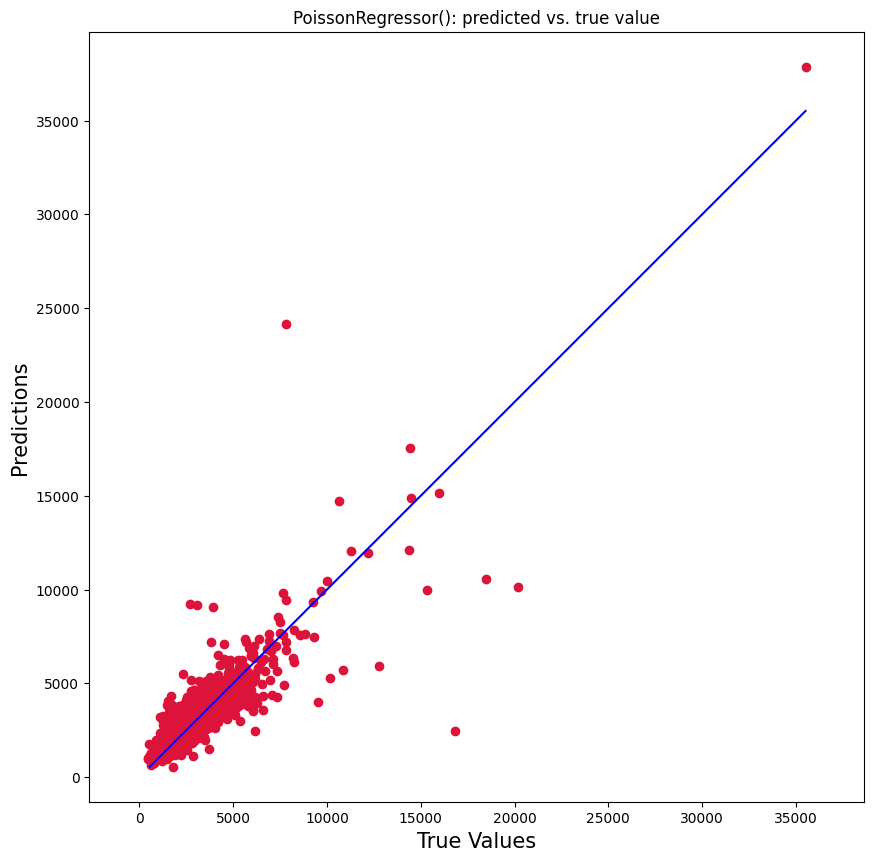

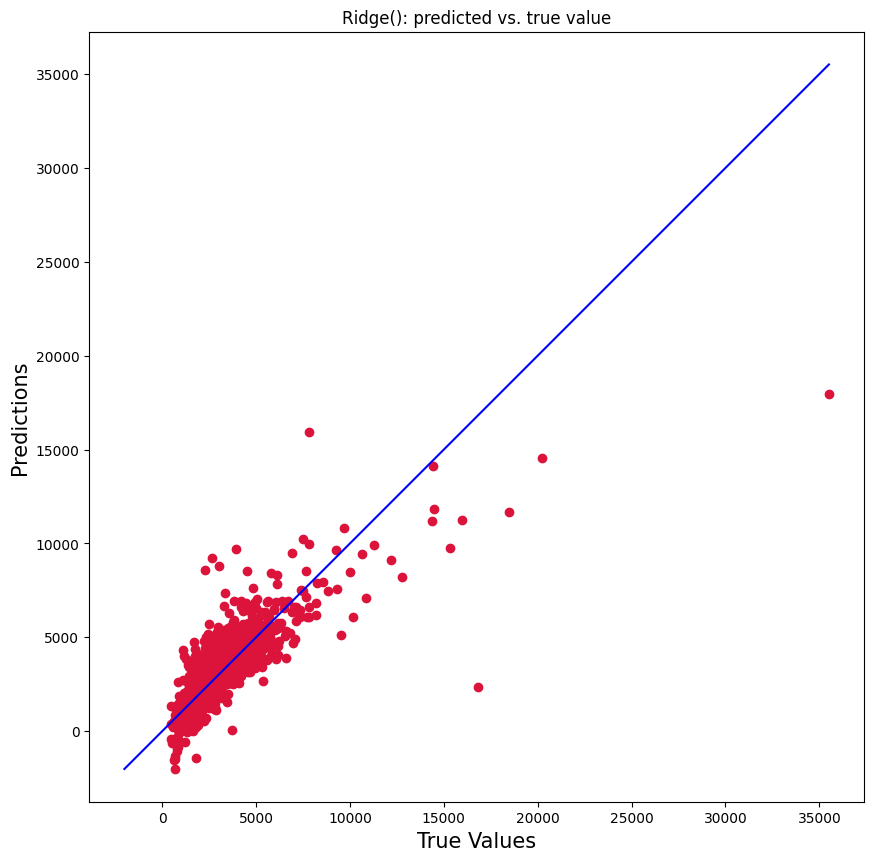

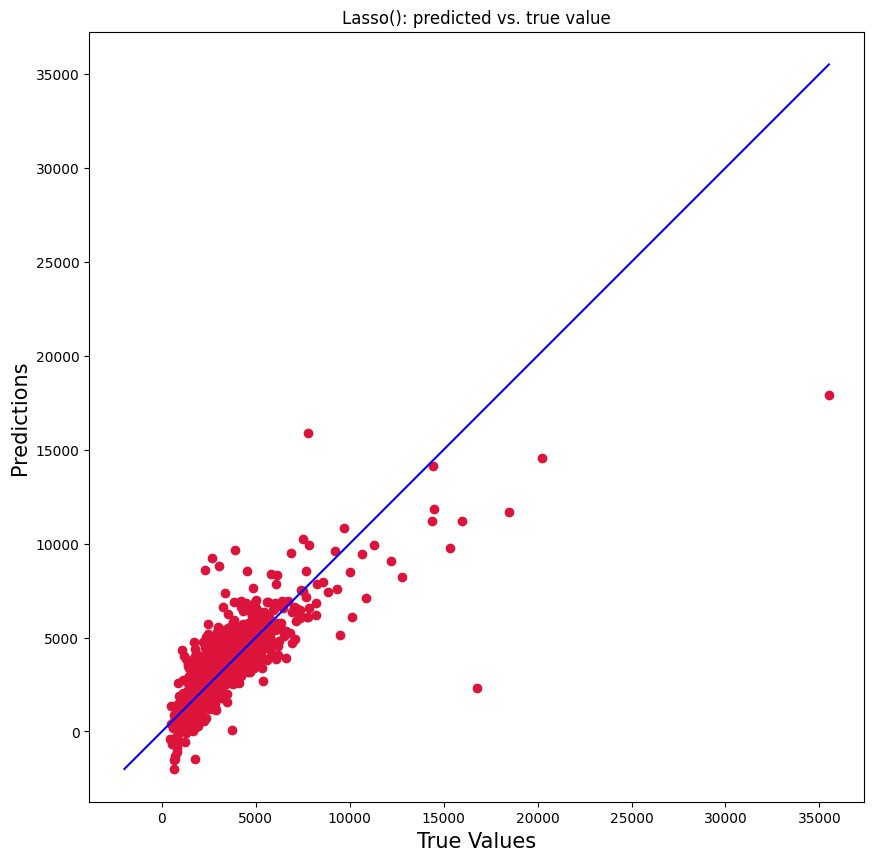

In [32]:
# True value, predicted value plots

# Use all data
X_train, X_test, y_train, y_test = split_data(df, test_size=0.2)
X_train = process_features(X_train)
X_test = process_features(X_test)

for model in models:
        
    plt.figure(figsize=(10,10))
    plt.title(f'{model}: predicted vs. true value')
    
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    
    plt.scatter(y_test, y_pred, c='crimson')
    # plt.yscale('log')
    # plt.xscale('log')

    p1 = max(max(y_test), max(y_test))
    p2 = min(min(y_pred), min(y_pred))
    plt.plot([p1, p2], [p1, p2], 'b-')
    plt.xlabel('True Values', fontsize=15)
    plt.ylabel('Predictions', fontsize=15)
    plt.axis('equal')
    plt.show()

In [ ]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

In [53]:
predictions

,Adjusted R-Squared,R-Squared,RMSE,Time Taken
Model,,,,
PoissonRegressor,0.70,0.72,1068.42,0.02
PassiveAggressiveRegressor,0.68,0.70,1101.94,0.01
RandomForestRegressor,0.68,0.70,1103.62,0.83
HuberRegressor,0.68,0.70,1117.24,0.03
GammaRegressor,0.66,0.68,1144.69,0.02
XGBRegressor,0.61,0.63,1226.47,0.14
LassoLarsCV,0.61,0.63,1229.35,0.04
LarsCV,0.61,0.63,1229.35,0.04
ExtraTreesRegressor,0.61,0.63,1232.59,0.45
